# Import stuff

In [1]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', font_scale=1.5)
from scipy import stats
import sys

from ipywidgets import IntProgress, Output, IntSlider
from IPython.display import display

# operon python bindings
import pyoperon as Operon

# Load some data

In [2]:
ds = Operon.Dataset('../data/Poly-10.csv', has_header=True)
training_range = Operon.Range(0, ds.Rows // 2)
test_range = Operon.Range(training_range.End, ds.Rows)

target = ds.GetVariable('Y')
y_train = ds.Values[0:training_range.End, target.Index]

inputs = Operon.VariableCollection(v for v in ds.Variables if v.Name != target.Name)

# Set up algorithm parameters

In [3]:
grammar = Operon.Grammar()
grammar.SetConfig(Operon.Grammar.Arithmetic | Operon.NodeType.Exp | Operon.NodeType.Log | Operon.NodeType.Sin | Operon.NodeType.Cos)

rng = Operon.RomuTrio(random.randint(1, 100000))
btc = Operon.BalancedTreeCreator(grammar, inputs, bias=0.0)

population_size = 1000
min_length, max_length = 1, 50
min_depth, max_depth = 1, 10
p_crossover = 1.0
p_mutation  = 0.25
p_internal = 0.9 # for crossover
initial_lengths = np.random.randint(min_length, max_length+1, population_size)
max_generations = 1000

# Set up genetic operators

In [4]:
crossover = Operon.SubtreeCrossover(p_internal, max_depth, max_length)
mut_onepoint = Operon.OnePointMutation()
mut_changeVar = Operon.ChangeVariableMutation(inputs)
mut_changeFunc = Operon.ChangeFunctionMutation(grammar)
mut_replace = Operon.ReplaceSubtreeMutation(btc, max_length, max_depth)
mutation = [ mut_onepoint, mut_changeFunc, mut_replace, mut_changeVar ]

def calculate_fitness(ind):
    y_pred = Operon.Evaluate(ind, ds, training_range)
    return Operon.RSquared(y_train, y_pred)
    
def select_tournament():
    i = random.randrange(population_size)
    for _ in range(1, 5):
        j = random.randrange(population_size)
        if fit[i] < fit[j]:
             i = j
    return i

def recombination():
    do_crossover = random.uniform(0, 1) < p_crossover
    do_mutation = random.uniform(0, 1) < p_mutation
    
    p1 = pop[select_tournament()]
    
    if do_crossover:
        p2 = pop[select_tournament()]
        child = crossover(rng, p1, p2)
    
    if do_mutation:
        op = random.choice(mutation)
        p1 = child if do_crossover else p1
        child = op(rng, child)
        
    return child if do_crossover or do_mutation else p1

# Run GP

In [11]:
pop = [btc(rng, length, 0, 0) for length in initial_lengths]
fit = [calculate_fitness(t) for t in pop]
idx = range(0, population_size)
arg_best = np.argmax(fit)

prog = IntProgress(min=0, max=max_generations, description='Evolution: ') # instantiate the bar
display(prog)

t0 = time.time()
for gen in range(max_generations+1):
    pop = [recombination() if i != arg_best else pop[arg_best] for i in idx ]
    fit = [calculate_fitness(pop[i]) if i != arg_best else fit[arg_best] for i in idx ]
    arg_best = np.argmax(fit)
    prog.value += 1
      
        
t1 = time.time()

print(f'\n best quality: {fit[arg_best]:.6f} elapsed: {t1-t0:.1f} seconds')

IntProgress(value=0, description='Evolution: ', max=1000)


 best quality: 0.999962 elapsed: 15.3 seconds


'## Model'

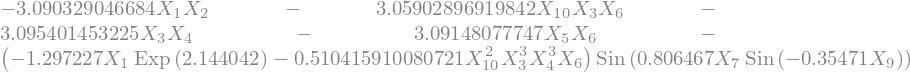

Simplified model


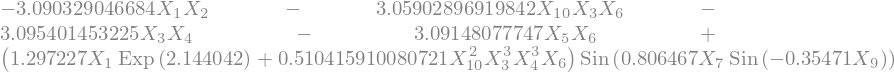

In [14]:
infix = Operon.InfixFormatter.Format(pop[arg_best], ds, 6)

import sympy as sy
from sympy.parsing.sympy_parser import parse_expr
from sympy import simplify

sy.init_printing(use_unicode=True)

expr = parse_expr(infix)
display('## Model')
display(expr)

print('Simplified model')
simplified = simplify(expr)
display(simplified)

# Visualize the results

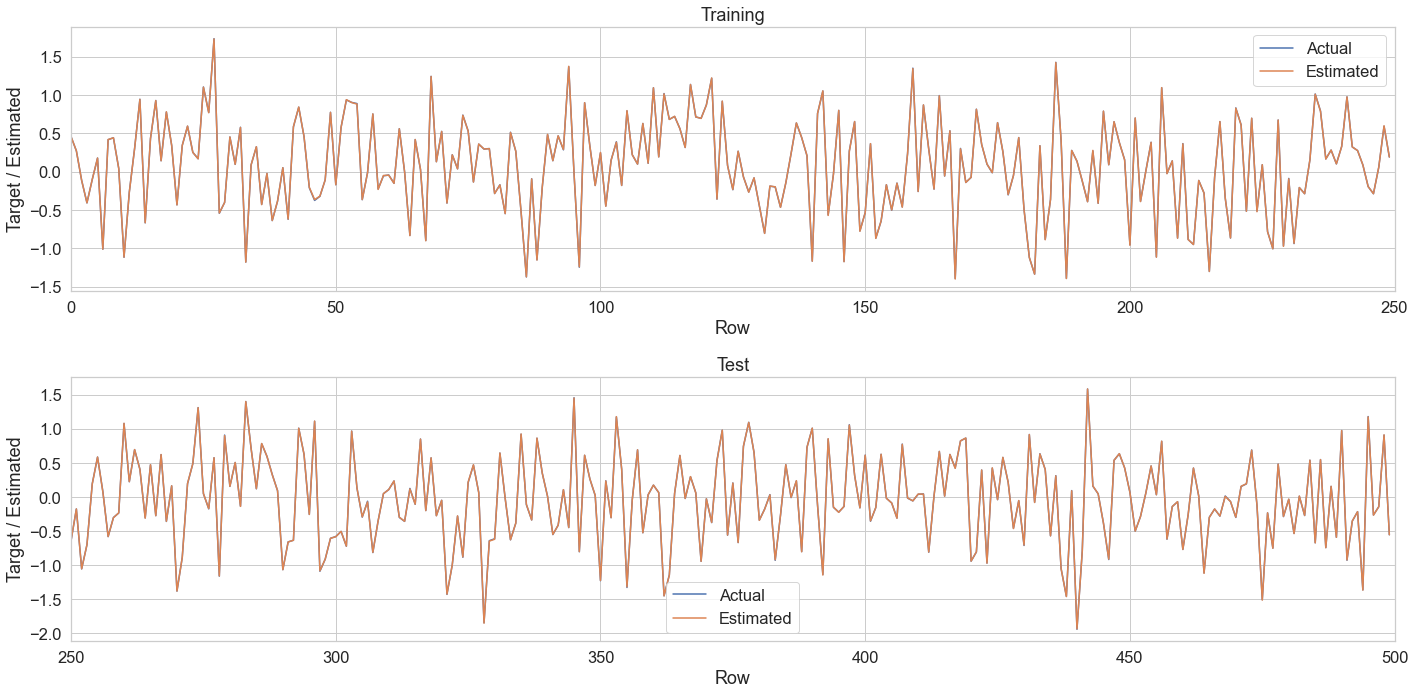

In [13]:
xs = range(0, ds.Rows)
y_target = ds.Values[0:ds.Rows, target.Index]

y_pred = Operon.Evaluate(pop[arg_best], ds, Operon.Range(0, ds.Rows))
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(y_pred.reshape(500, 1), y_target)
y_scaled = lr.coef_ * y_pred + lr.intercept_

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

ax = axes[0]
sns.lineplot(ax=ax, x=xs[training_range.Start:training_range.End], y=y_target[training_range.Start:training_range.End], label='Actual')
sns.lineplot(ax=ax, x=xs[training_range.Start:training_range.End], y=y_scaled[training_range.Start:training_range.End], label='Estimated')
ax.set(xlabel='Row', ylabel='Target / Estimated', title='Training')
ax.set_xlim(training_range.Start, training_range.End)

ax = axes[1]
sns.lineplot(ax=ax, x=xs[test_range.Start:test_range.End], y=y_target[test_range.Start:test_range.End], label='Actual')
sns.lineplot(ax=ax, x=xs[test_range.Start:test_range.End], y=y_scaled[test_range.Start:test_range.End], label='Estimated')
ax.set(xlabel='Row', ylabel='Target / Estimated', title='Test')
ax.set_xlim(test_range.Start, test_range.End)

plt.tight_layout()